<a href="https://colab.research.google.com/github/tnvsl/Projects/blob/main/HMM%20POS-tagger.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Скрытая Марковская модель (HMM)**

Скрытая Марковская модель - это вероятностная модель последовательности, которая состоит из набора наблюдаемых переменных X = {x1,...,xN} и скрытых
переменных(переменные состояния) T = {t1 ,...,tN}. Целью модели является как можно точнее смоделировать статические свойства источников сигналов.

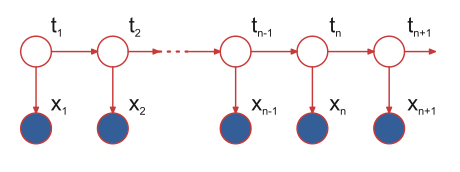

Наблюдаемые переменные - слова

Скрытые переменные - теги

Модель не имеет точной информации о тегах, но знает общие тенденции. Основываясь на том, какие теги были у слов в обучающей выборке, модель пытается угадать, какой тег будет у новых слов.

1 Этап. Обучение модели. 

Импортируем библиотеки

In [ ]:
from google.colab import drive
import nltk
import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split
import pprint, time

Для обучения используем материалы DIALOGUE EVALUATION 2017
Морфологический анализ (General Internet-Corpus of Russian)

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
with open("/content/drive/MyDrive/МСП/gikrya_train.txt") as f:
  data = f.read()

Посмотрим, как выглядят наши данные. Выведем первые 3 предложения:

In [ ]:
sent = data.split('\n\n')
for i in range(3):
  print(sent[i])
  print('')

1	Чья-то	чей-то	DET	Case=Nom|Gender=Fem|Number=Sing
2	рука	рука	NOUN	Animacy=Inan|Case=Nom|Gender=Fem|Number=Sing
3	легла	лечь	VERB	Gender=Fem|Mood=Ind|Number=Sing|Tense=Past|VerbForm=Fin|Voice=Act
4	ему	он	PRON	Case=Dat|Gender=Masc|Number=Sing|Person=3
5	на	на	ADP	_
6	плечо	плечо	NOUN	Animacy=Inan|Case=Acc|Gender=Neut|Number=Sing
7	.	.	PUNCT	_

1	Он	он	PRON	Case=Nom|Gender=Masc|Number=Sing|Person=3
2	не	не	PART	_
3	голодал	голодать	VERB	Gender=Masc|Mood=Ind|Number=Sing|Tense=Past|VerbForm=Fin|Voice=Act
4	,	,	PUNCT	_
5	не	не	PART	_
6	мерз	мёрзнуть	VERB	Gender=Masc|Mood=Ind|Number=Sing|Tense=Past|VerbForm=Fin|Voice=Act
7	на	на	ADP	_
8	вокзале	вокзал	NOUN	Animacy=Inan|Case=Loc|Gender=Masc|Number=Sing
9	под	под	ADP	_
10	дождем	дождь	NOUN	Animacy=Inan|Case=Ins|Gender=Masc|Number=Sing
11	,	,	PUNCT	_
12	его	он	PRON	Case=Acc|Gender=Masc|Number=Sing|Person=3
13	не	не	PART	_
14	унижали	унижать	VERB	Mood=Ind|Number=Plur|Tense=Past|VerbForm=Fin|Voice=Act
15	,	,	PUNCT	_
16	не	не	PART	_
17	били	бит

In [ ]:
for i in sent[-5:]:
  print(i, '\n')

1	И	и	CONJ	_
2	даже	даже	PART	_
3	хлам	хлам	NOUN	Animacy=Inan|Case=Nom|Gender=Masc|Number=Sing
4	как_будто	как_будто	CONJ	_
5	тихо	тихо	ADV	Degree=Pos
6	дышит	дышать	VERB	Mood=Ind|Number=Sing|Person=3|Tense=Notpast|VerbForm=Fin|Voice=Act
7	.	.	PUNCT	_ 

1	Но	но	CONJ	_
2	не	не	PART	_
3	это	это	PRON	Case=Nom|Gender=Neut|Number=Sing
4	было	быть	VERB	Gender=Neut|Mood=Ind|Number=Sing|Tense=Past|VerbForm=Fin|Voice=Act
5	главное	главный	ADJ	Case=Nom|Degree=Pos|Gender=Neut|Number=Sing
6	!	!	PUNCT	_ 

1	Там	там	ADV	Degree=Pos
2	могут	мочь	VERB	Mood=Ind|Number=Plur|Person=3|Tense=Notpast|VerbForm=Fin|Voice=Act
3	быть	быть	VERB	VerbForm=Inf
4	и	и	CONJ	_
5	фрески	фреска	NOUN	Animacy=Inan|Case=Nom|Gender=Fem|Number=Plur
6	,	,	PUNCT	_
7	и	и	CONJ	_
8	другие	другой	DET	Case=Nom|Number=Plur
9	памятники	памятник	NOUN	Animacy=Inan|Case=Nom|Gender=Masc|Number=Plur
10	.	.	PUNCT	_ 

1	Без	без	ADP	_
2	сил	сила	NOUN	Animacy=Inan|Case=Gen|Gender=Fem|Number=Plur
3	она	он	PRON	Case=Nom|Gender=Fem|Number=Sing|Per

In [ ]:
# в файле последнее предложение - пустая строка, так что мы удаляем ее, чтобы она не мешала
sent.remove('')

In [ ]:
# представляем данные в виде списка, который содержит другие списки, каждый из
# которых соответствует одному предложению и содержит все слова и их теги в виде кортежа (слово, тег)
tokens = []
for sentence in sent:
  s = []
  for word in sentence.split('\n'):
      token = (word.split()[1], word.split()[3])
      s.append(token)
  tokens.append(s)


In [ ]:
print(tokens[0:10])

[[('Чья-то', 'DET'), ('рука', 'NOUN'), ('легла', 'VERB'), ('ему', 'PRON'), ('на', 'ADP'), ('плечо', 'NOUN'), ('.', 'PUNCT')], [('Он', 'PRON'), ('не', 'PART'), ('голодал', 'VERB'), (',', 'PUNCT'), ('не', 'PART'), ('мерз', 'VERB'), ('на', 'ADP'), ('вокзале', 'NOUN'), ('под', 'ADP'), ('дождем', 'NOUN'), (',', 'PUNCT'), ('его', 'PRON'), ('не', 'PART'), ('унижали', 'VERB'), (',', 'PUNCT'), ('не', 'PART'), ('били', 'VERB'), ('.', 'PUNCT')], [('А', 'CONJ'), ('с', 'ADP'), ('дальнего', 'ADJ'), ('конца', 'NOUN'), ('лагеря', 'NOUN'), ('распространялся', 'VERB'), ('аромат', 'NOUN'), ('жаркого', 'NOUN'), ('.', 'PUNCT')], [('Потратил', 'VERB'), ('кучу', 'NOUN'), ('денег', 'NOUN'), ('по', 'ADP'), ('моему', 'DET'), ('мнению', 'NOUN'), ('лишь', 'CONJ'), ('для', 'ADP'), ('того', 'PRON'), ('чтобы', 'CONJ'), ('поехать', 'VERB'), ('в', 'ADP'), ('пригород', 'NOUN'), ('и', 'PART'), ('встретится', 'VERB'), ('с', 'ADP'), ('двумя', 'NUM'), ('девочками', 'NOUN'), (',', 'PUNCT'), ('в', 'ADP'), ('этом', 'PRON'), (

In [ ]:
# смотрим сколько всего у нас предложений
print(len(sent))

62361


In [ ]:
# делим даннные на обучающую и тестовую выборки в соотношении 80:20
# данные выбираются рандомно, random_state - фиксирует набор
train_set,test_set =train_test_split(tokens, train_size=0.80,test_size=0.20,random_state = 101)

In [ ]:
print(len(train_set))
print(len(test_set))

49888
12473


In [ ]:
# из списка списков создаем список размеченных обучающих и тестовых данных
train_tagged_words = [ tup for sent in train_set for tup in sent ]
test_tagged_words = [ tup for sent in test_set for tup in sent ]
print(len(train_tagged_words))
print(len(test_tagged_words))

651946
163938


In [ ]:
# проверяем первые 5 размеченных слов в обучающей выборке
train_tagged_words[:5]

[('Зачем', 'ADV'),
 ('вам', 'PRON'),
 ('тратить', 'VERB'),
 ('годы', 'NOUN'),
 ('на', 'ADP')]

In [ ]:
# смотрим сколько уникальных тегов присутствует в обучающей выборке
tags = {tag for word,tag in train_tagged_words}
print(len(tags))
print(tags)
 
# проверяем общее количество слов
vocab = {word for word,tag in train_tagged_words}

13
{'PART', 'INTJ', 'NUM', 'DET', 'CONJ', 'ADV', 'PUNCT', 'ADJ', 'H', 'VERB', 'PRON', 'NOUN', 'ADP'}


In [ ]:
print(len(vocab))

94390


Для каждого состояния скрытой марковской модели задан вектор вероятности эмиссии(выбросов), который характеризует вероятность наблюдения каждого события, когда модель находится в этом состоянии. 

В нашем случае эмиссия - насколько вероятно, что конкретное слово будет иметь конкретный тег.

Совокупность таких векторов образует матрицу эмиссии.

In [ ]:
# рассчитываем вероятности эмиссии
# они определяют вероятность увидеть определенную наблюдаемую переменную при заданном значении для скрытых переменных, 
# т.е. эта функция возвращает то, сколько всего раз тег встречался в выборке и сколько раз определенное слово встречалось с этим тегом 
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag] # список всех слов определенного тега
    count_tag = len(tag_list)# общее число появления тегов в обучающей выборке
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word] # cписок, который состоит из всех вхождений данного слова, которые были помечены определенным тегом
# подсчитываем общее количество раз, когда слово встречалось с тегом
    count_w_given_tag = len(w_given_tag_list)
   
    return (count_w_given_tag, count_tag)

ЯНА

[**Вероятность перехода**](http://stratum.ac.ru/education/textbooks/modelir/lection33.html)

Модель марковского процесса представим в виде графа, в котором состояния (вершины) связаны между собой связями (переходами из i-го состояния в j-е состояние)

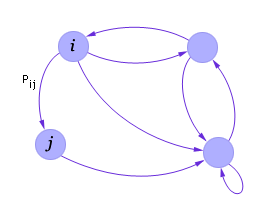

Каждый переход характеризуется вероятностью перехода Pij. Вероятность Pij показывает, как часто после попадания в i-е состояние осуществляется затем переход в j-е состояние. 

Таким образом, реализация марковского процесса представляет собой вычисление последовательности (цепи) переходов из состояния в состояние. 
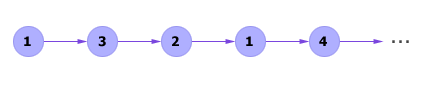



In [ ]:
# рассчитаем вероятность переходов
def t2_given_t1(t2, t1, train_bag = train_tagged_words): # t1 = t2, это пронумерованный список тегов
    tags = [pair[1] for pair in train_bag] # список всех тегов по порядку (просто из общего спсика размеченных слов мы убираем слова, получаем последовательность тегов)
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2: # если при теге t1 следующий тег = t2, то осуществляется переход
            count_t2_t1 += 1
    return (count_t2_t1, count_t1) # сколько всего раз встречается данный (второе значение), сколько раз данный тег переходит в другой тег (первое значение)

In [ ]:
# создаем матрицу тегов t x t, где t - номер тега
# матрица(i, j) представляет вероятность перехода P(i-й тег переходит в j-й тег)
 
tags_matrix = np.zeros((len(tags), len(tags)), dtype='float32')
for i, t1 in enumerate(list(tags)):
    for j, t2 in enumerate(list(tags)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]
 
print(tags_matrix)

[[4.70535792e-02 4.05284918e-05 8.87573976e-03 2.93831564e-02
  8.63256864e-03 8.04490522e-02 4.62024808e-02 7.98816532e-02
  4.05284925e-04 4.83221203e-01 6.22112341e-02 8.07327554e-02
  7.29107559e-02]
 [8.01393762e-02 3.48432059e-03 1.74216030e-03 6.96864119e-03
  8.01393762e-02 7.83972144e-02 5.62717795e-01 2.43902430e-02
  5.22648077e-03 3.83275263e-02 7.49128908e-02 1.74216032e-02
  2.61324048e-02]
 [7.80559657e-03 0.00000000e+00 8.83652456e-03 1.23711340e-02
  1.00147277e-02 1.26656853e-02 8.57142881e-02 9.14580300e-02
  2.94550817e-04 2.87187044e-02 8.98379926e-03 6.47569954e-01
  8.55670124e-02]
 [2.94617787e-02 0.00000000e+00 5.02234371e-03 2.10780241e-02
  6.05053967e-03 2.08012015e-02 5.72626255e-02 1.29908651e-01
  1.58184048e-04 7.30414838e-02 2.93826871e-02 6.09206319e-01
  1.86261721e-02]
 [7.12699965e-02 3.31725751e-04 7.45107047e-03 4.57526334e-02
  1.71476696e-02 1.09061219e-01 2.41394266e-02 9.66852978e-02
  3.11311847e-03 1.98550612e-01 1.61754578e-01 1.77039474e-0

**Матрица перехода тегов(состояний)**

Матрица задает вероятность перехода из каждого тега в каждый. 

Наглядно модель марковского процесса можно представить себе в виде следующего графа:
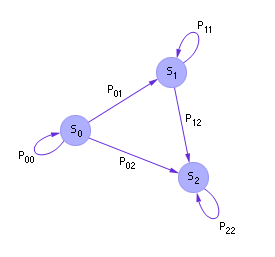


In [ ]:
tags_df = pd.DataFrame(tags_matrix, columns = list(tags), index=list(tags))
display(tags_df)

,PART,INTJ,NUM,DET,CONJ,ADV,PUNCT,ADJ,H,VERB,PRON,NOUN,ADP
PART,0.047054,0.000041,0.008876,0.029383,0.008633,0.080449,0.046202,0.079882,0.000405,0.483221,0.062211,0.080733,0.072911
INTJ,0.080139,0.003484,0.001742,0.006969,0.080139,0.078397,0.562718,0.024390,0.005226,0.038328,0.074913,0.017422,0.026132
NUM,0.007806,0.000000,0.008837,0.012371,0.010015,0.012666,0.085714,0.091458,0.000295,0.028719,0.008984,0.647570,0.085567
DET,0.029462,0.000000,0.005022,0.021078,0.006051,0.020801,0.057263,0.129909,0.000158,0.073041,0.029383,0.609206,0.018626
CONJ,0.071270,0.000332,0.007451,0.045753,0.017148,0.109061,0.024139,0.096685,0.003113,0.198551,0.161755,0.177039,0.087703
ADV,0.086545,0.000203,0.015268,0.019117,0.016534,0.081455,0.163569,0.108497,0.000177,0.293437,0.078493,0.060389,0.076315
PUNCT,0.041454,0.004856,0.009611,0.042863,0.224409,0.096228,0.031324,0.080171,0.011993,0.115832,0.127298,0.123106,0.090845
ADJ,0.010977,0.000000,0.004121,0.009159,0.028482,0.014839,0.139434,0.070747,0.000087,0.055389,0.013401,0.592139,0.061224
H,0.013029,0.000000,0.000000,0.010423,0.003257,0.020847,0.791531,0.018241,0.000000,0.046254,0.050163,0.025407,0.020847
VERB,0.032315,0.000064,0.010369,0.045260,0.023494,0.068193,0.231422,0.095779,0.000170,0.080247,0.068394,0.160823,0.183469


**Алгоритм Витерби**

Алгоритм поиска наиболее подходящего списка состояний, который в контексте цепей Маркова получает наиболее вероятную последовательность скрытых состояний с учётом наблюдающейся последовательности в модели.

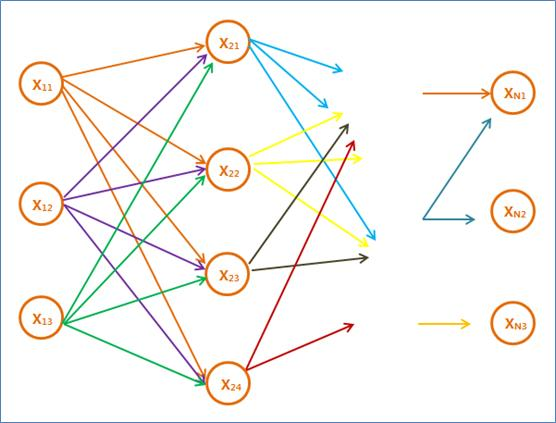

In [ ]:
print(train_tagged_words[0:10])

[('Зачем', 'ADV'), ('вам', 'PRON'), ('тратить', 'VERB'), ('годы', 'NOUN'), ('на', 'ADP'), ('дорогу', 'NOUN'), (',', 'PUNCT'), ('которая', 'DET'), ('у', 'ADP'), ('ваших', 'DET')]


In [ ]:
def Viterbi(words, train_bag = train_tagged_words): # первый аргумент - список слов, которым нам нужно присвоить тег, второй - размеченная обучающая выборка 
    state = []
    T = list(set([pair[1] for pair in train_bag])) # список всех возможных тегов
     
    for key, word in enumerate(words): # пронумеровываем список слов, чтобы можно было смотреть на предыдущее
        p = [] # инициализируем список столбцов вероятности для каждого наблюдения
        for tag in T: # считаем вероятность перехода
            if key == 0: # если предыдущего тега нет, то рассматриваем вероятность появления слова после знака препинания, в начале предложения
                transition_p = tags_df.loc['PUNCT', tag] 
            else: # если предыдущий тег есть, то рассматриваем его
                transition_p = tags_df.loc[state[-1], tag]
                 
            # вычисляем вероятности выбросов и состояний
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1] # вероятность выбросов ( насколько вероятно, что конкретное слово будет иметь конкретный тег)
            state_probability = emission_p * transition_p  # вероятность состояний (умножаем веротность того, что слово в принципе встречалось с этим тегом на вероятность перехода)
            p.append(state_probability) 

             
        pmax = max(p) # выбираем максимальное значение из полученного списка
        # получаем наиболее вероятную последовательность скрытых состояний
        state_max = T[p.index(pmax)] # записываем его индекс и находим его соответствие в списке тегов 
        state.append(state_max)
    return list(zip(words, state))

In [ ]:
# протестируем алгоритм Витерби на нескольких примерах предложений тестового набора данных
random.seed(1234)      #определяем случайное значение
 
# выбираем случайные 10 значений
rndom = [random.randint(1,len(test_set)) for x in range(10)]
 
# список из 10 предложений, на которых мы тестируем модель
test_run = [test_set[i] for i in rndom]
 
# список размеченных слов
test_run_base = [tup for sent in test_run for tup in sent]
 
# список неразмеченных слов
test_tagged_words = [tup[0] for sent in test_run for tup in sent]

In [ ]:
print(len(test_tagged_words))

100


Проверяем скорость и точность алгоритма

In [ ]:
start = time.time()
tagged_seq = Viterbi(test_tagged_words)
end = time.time() # считаем сколько времени это заняло 
difference = end-start
 
print("Время в секундах: ", difference)
 
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j]  
 
accuracy = len(check)/len(tagged_seq) # считаем точность
print('Точность алгоритма Витерби: ',accuracy*100)

Время в секундах:  296.45626759529114
Точность алгоритма Витерби:  93.0


In [ ]:
for elem in tagged_seq[:12]:
  print(elem)

('У', 'ADP')
('страны', 'NOUN')
('было', 'VERB')
('трудное', 'ADJ')
('время', 'NOUN')
('.', 'PUNCT')
('Том', 'NOUN')
('осторожно', 'ADV')
('отвел', 'VERB')
('ее', 'DET')
('руку', 'NOUN')
('.', 'PUNCT')


Источники:

1. A Guide to Hidden Markov Model and its Applications in NLP (https://analyticsindiamag.com/a-guide-to-hidden-markov-model-and-its-applications-in-nlp/)

2. Датасет: General Internet-Corpus of Russian (https://github.com/dialogue-evaluation/morphoRuEval-2017/blob/master/Baseline.zip)